In [8]:
# Librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

# Cargar el dataset
data_path = '/content/jena_climate_2009_2016.csv'  # Ajustar la ruta si es necesario
df = pd.read_csv(data_path)

# Visualización de las primeras filas para confirmar la estructura
print(df.head())

# Selección de la variable de interés (temperatura en grados centígrados)
temperature = df['T (degC)'].values

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

In [9]:
# Parámetros del dataset de series temporales
sampling_rate = 1  # Un paso por hora
sequence_length = 24 * 7  # Se usa una semana de datos (24 horas * 7 días)
delay = 24  # Desplazamiento de 24 horas en la etiqueta para predecir la temperatura al día siguiente
batch_size = 32  # Tamaño de lote para entrenar

# Creación de los conjuntos de entrenamiento, validación y prueba
split_time = int(len(temperature) * 0.7)
train_data = temperature[:split_time]
val_data = temperature[split_time:]

# Preparación de datasets de series temporales para entrenamiento, validación y prueba
train_dataset = timeseries_dataset_from_array(
    data=train_data,
    targets=train_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

val_dataset = timeseries_dataset_from_array(
    data=val_data,
    targets=val_data[delay:],
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

In [10]:
# Construcción del modelo LSTM
model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    layers.LSTM(32),
    layers.Dense(1)  # Capa de salida para predicción de temperatura
])

# Compilación del modelo con MAE para interpretación directa en °C
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Entrenamiento del modelo
history = model.fit(
    train_dataset,
    epochs=15,  # Ajustar según necesidad
    validation_data=val_dataset
)

Epoch 1/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 180s 20ms/step - loss: 3.1596 - mae: 3.1596 - val_loss: 2.4028 - val_mae: 2.4028
Epoch 2/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 201s 19ms/step - loss: 2.3432 - mae: 2.3432 - val_loss: 2.0624 - val_mae: 2.0624
Epoch 3/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 178s 19ms/step - loss: 1.9434 - mae: 1.9434 - val_loss: 1.9669 - val_mae: 1.9669
Epoch 4/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 176s 19ms/step - loss: 1.6660 - mae: 1.6660 - val_loss: 1.5842 - val_mae: 1.5842
Epoch 5/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 179s 19ms/step - loss: 1.5712 - mae: 1.5712 - val_loss: 1.2024 - val_mae: 1.2024
Epoch 6/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 178s 19ms/step - loss: 1.0792 - mae: 1.0792 - val_loss: 0.7563 - val_mae: 0.7563
Epoch 7/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 177s 19ms/step - loss: 0.7315 - mae: 0.7315 - val_loss: 0.4380 - val_mae: 0.4380
Epoch 8/15
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 178s 19ms/step - loss: 0.4912 - mae: 0.4912 - val_loss: 0.3706 - val_mae: 0.3706
Epoch 9/15
9195/

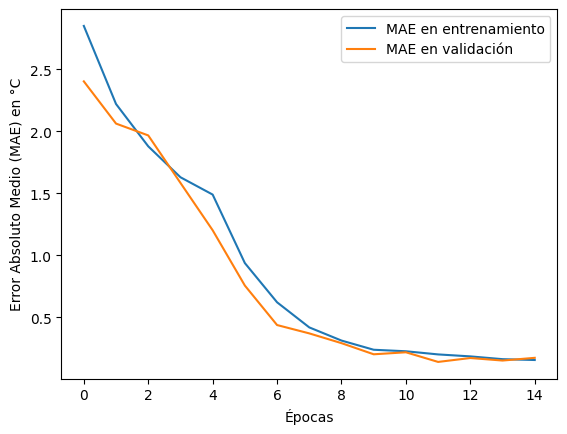

3938/3938 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.1577 - mae: 0.1577
Error absoluto medio en el conjunto de validación: 0.17°C
El modelo tiene un error promedio de 0.17 grados centígrados en las predicciones de temperatura para el siguiente día.


In [13]:
# Gráfica de la pérdida para visualizar el ajuste del modelo
plt.plot(history.history['mae'], label='MAE en entrenamiento')
plt.plot(history.history['val_mae'], label='MAE en validación')
plt.xlabel('Épocas')
plt.ylabel('Error Absoluto Medio (MAE) en °C')
plt.legend()
plt.show()

# Evaluación final en el conjunto de validación
val_mae = model.evaluate(val_dataset)
print(f"Error absoluto medio en el conjunto de validación: {val_mae[1]:.2f}°C")

# Interpretación final de la métrica
print(f"El modelo tiene un error promedio de {val_mae[1]:.2f} grados centígrados en las predicciones de temperatura para el siguiente día.")